<a href="https://colab.research.google.com/github/samarth2015/CS203_Lab_4/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task 1: Setup the dataset

- Load the MNIST dataset using the Hugging Face datasets library.
- Convert the image data into Numpy arrays and normalize pixel values to the range [0,1].
- Flatten each image into a vector of 784 features.
- Split the dataset into training and testing sets.
- Randomly select an initially labeled dataset of 200 samples from training samples.
- Generate an "Unlabeled Pool," the Initial Dataset excluding 200 samples.

In [8]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_syste

In [10]:
import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
data = datasets.load_dataset("mnist")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [12]:
# convert the image data into a numpy array and normalize the values from 0 to 1
X = np.array(data['train']["image"]) / 255
y = np.array(data['train']["label"])


In [13]:
X = X.reshape(X.shape[0], -1)
X.shape

(60000, 784)

In [14]:
X_test = np.array(data['test']["image"]) / 255
y_test = np.array(data['test']["label"])

# flatten the test data
X_test = X_test.reshape(X_test.shape[0], -1)

In [15]:
# randomly select 200 samples from training dataset and create a labelled dataset
np.random.seed(45)
idx = np.random.choice(X.shape[0], 200, replace=False)
X_train_labelled = X[idx]
y_train_labelled = y[idx]

In [16]:
# create a pool of unlabelled data
X_train_unlabelled = np.delete(X, idx, axis=0)
y_train_unlabelled = np.delete(y, idx, axis=0)

X_train_unlabelled.shape


(59800, 784)

## Task 2: Implement Random Sampling for Active Learning


- Train a Random Forest Classifier (you can use “from sklearn.ensemble import RandomForestClassifier”)  on the initial dataset of 200 samples.
- Implement an active learning loop for 20 iterations:
    - Randomly select a sample from the unlabeled pool.
    - Get the selected sample and its true label.
    - Add the sample and label to the labeled dataset.
    - Remove the selected sample and label from the pool.
    - Retrain the model on the updated dataset.
    - Check the model's accuracy on the test set.
    - Print accuracy after every iteration.


In [17]:
from sklearn.ensemble import RandomForestClassifier

# train a random forest classifier on the labelled data
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_labelled, y_train_labelled)

# predict the unlabelled data
y_prediction = clf.predict(X_test)

# calculate the accuracy of the classifier
accuracy = np.mean(y_test == y_prediction)
accuracy

0.7777

In [18]:
# implementing active learning by for 20 iterations by randomly choosing the samples from the unlabelled pool.
task1_results = []
for i in range(20):
    idx_curr = np.random.choice(X_train_unlabelled.shape[0], 1, replace=False) # randomly select 1 sample

    # add the sample to the labelled dataset
    X_train_labelled = np.concatenate([X_train_labelled, X_train_unlabelled[idx_curr]])
    y_train_labelled = np.concatenate([y_train_labelled, y_train_unlabelled[idx_curr]])

    # remove the sample from the unlabelled dataset
    X_train_unlabelled = np.delete(X_train_unlabelled, idx_curr, axis=0)
    y_train_unlabelled = np.delete(y_train_unlabelled, idx_curr, axis=0)

    # retrain the classifier
    clf.fit(X_train_labelled, y_train_labelled)

    # predict the unlabelled data
    y_prediction= clf.predict(X_test)

    # calculate the accuracy of the classifier
    accuracy = np.mean(y_test == y_prediction)
    task1_results.append(accuracy)
    print(f"Iteration: {i} Accuracy: {accuracy}")


Iteration: 0 Accuracy: 0.7705
Iteration: 1 Accuracy: 0.7791
Iteration: 2 Accuracy: 0.7682
Iteration: 3 Accuracy: 0.7717
Iteration: 4 Accuracy: 0.776
Iteration: 5 Accuracy: 0.7863
Iteration: 6 Accuracy: 0.7662
Iteration: 7 Accuracy: 0.7782
Iteration: 8 Accuracy: 0.7798
Iteration: 9 Accuracy: 0.7889
Iteration: 10 Accuracy: 0.7819
Iteration: 11 Accuracy: 0.7795
Iteration: 12 Accuracy: 0.7835
Iteration: 13 Accuracy: 0.7845
Iteration: 14 Accuracy: 0.7868
Iteration: 15 Accuracy: 0.7984
Iteration: 16 Accuracy: 0.8022
Iteration: 17 Accuracy: 0.7971
Iteration: 18 Accuracy: 0.7862
Iteration: 19 Accuracy: 0.7971


## Task 3: Implement Uncertainty Sampling for Active Learning.

- Train a Random Forest Classifier (you can use “from sklearn.ensemble import RandomForestClassifier”)  on the initial dataset of 200 samples.
- Implement an active learning loop for 20 iterations:
    - Compute uncertainty (Label Entropy) for each sample in the unlabeled pool using entropy.
    - Select the sample with the highest uncertainty and query its true label.
    - Add the queried sample to the labelled dataset and remove it from the unlabelled pool.
    - Retrain the model and check the model's accuracy on the test set.
    - Print accuracy after every iteration


In [19]:
np.random.seed(45)
idx = np.random.choice(X.shape[0], 200, replace=False)
X_train_labelled = X[idx]
y_train_labelled = y[idx]

X_train_unlabelled=np.delete(X,idx,axis=0)
y_train_unlabelled=np.delete(y,idx,axis=0)


In [20]:
X_train_unlabelled.shape
# Y_train_unlabelled.shape


(59800, 784)

In [21]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train_labelled,y_train_labelled)
y_prediction=clf.predict(X_test)
accuracy=np.mean(y_test==y_prediction)
accuracy

0.7777

In [22]:
def labelentropy(probability):
    max_entropy=float('-inf')
    epsilon=1e-10
    maxind=-1
    for i in range(len(probability)):
        ent=np.sum(probability[i]*np.log10(probability[i]+epsilon))
        if(ent>max_entropy):
            max_entropy=ent
            maxind=i
    return [maxind]

In [23]:
X_train_unlabelled[0].shape

(784,)

In [24]:
task2_results=[]
for i in range(20):
    probability=clf.predict_proba(X_train_unlabelled)
    idx_curr=labelentropy(probability)

    # add the sample to the labelled dataset
    X_train_labelled = np.concatenate([X_train_labelled, X_train_unlabelled[idx_curr]])
    y_train_labelled = np.concatenate([y_train_labelled, y_train_unlabelled[idx_curr]])

    # remove the sample from the unlabelled dataset
    X_train_unlabelled = np.delete(X_train_unlabelled, idx_curr, axis=0)
    y_train_unlabelled = np.delete(y_train_unlabelled, idx_curr, axis=0)

    # retrain the classifier
    clf.fit(X_train_labelled, y_train_labelled)

    # predict the unlabelled data
    y_prediction= clf.predict(X_test)

    # calculate the accuracy of the classifier
    accuracy = np.mean(y_test == y_prediction)
    task2_results.append(accuracy)
    print(f"Iteration: {i} Accuracy: {accuracy}")



Iteration: 0 Accuracy: 0.7768
Iteration: 1 Accuracy: 0.7755
Iteration: 2 Accuracy: 0.7662
Iteration: 3 Accuracy: 0.7732
Iteration: 4 Accuracy: 0.7787
Iteration: 5 Accuracy: 0.7807
Iteration: 6 Accuracy: 0.7831
Iteration: 7 Accuracy: 0.7743
Iteration: 8 Accuracy: 0.7662
Iteration: 9 Accuracy: 0.7675
Iteration: 10 Accuracy: 0.7632
Iteration: 11 Accuracy: 0.776
Iteration: 12 Accuracy: 0.7718
Iteration: 13 Accuracy: 0.7695
Iteration: 14 Accuracy: 0.7694
Iteration: 15 Accuracy: 0.7742
Iteration: 16 Accuracy: 0.7725
Iteration: 17 Accuracy: 0.7874
Iteration: 18 Accuracy: 0.7797
Iteration: 19 Accuracy: 0.7756


## Task 4: Implement Query-by-Committee for Active Learning

In [25]:
np.random.seed(45)
idx = np.random.choice(X.shape[0], 200, replace=False)
X_train_labelled = X[idx]
y_train_labelled = y[idx]

X_train_unlabelled=np.delete(X,idx,axis=0)
y_train_unlabelled=np.delete(y,idx,axis=0)

In [26]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train_labelled,y_train_labelled)
y_prediction=clf.predict(X_test)


In [27]:
clf1=RandomForestClassifier(n_estimators=100)
clf1.fit(X_train_labelled,y_train_labelled)
y_prediction=clf1.predict(X_test)


In [28]:
clf2=RandomForestClassifier(n_estimators=100)
clf2.fit(X_train_labelled,y_train_labelled)
y_prediction=clf2.predict(X_test)


In [29]:
clf3=RandomForestClassifier(n_estimators=100)
clf3.fit(X_train_labelled,y_train_labelled)
y_prediction=clf3.predict(X_test)


In [30]:
clf4=RandomForestClassifier(n_estimators=100)
clf4.fit(X_train_labelled,y_train_labelled)
y_prediction=clf4.predict(X_test)


In [31]:
print(len(X_train_unlabelled))

59800


In [32]:
def voteentropy(X_train_unlabelled, clf, clf1, clf2, clf3, clf4):
    # Stack the predictions from all classifiers into a 2D array
    predictions = np.array([
        clf.predict(X_train_unlabelled),
        clf1.predict(X_train_unlabelled),
        clf2.predict(X_train_unlabelled),
        clf3.predict(X_train_unlabelled),
        clf4.predict(X_train_unlabelled)
    ])

    # Transpose predictions to have shape (5, n_samples)
    predictions = predictions.T  # Now shape is (n_samples, 5)

    # Initialize an empty array for storing probabilities
    prob = np.zeros((predictions.shape[0], 10))

    # Add 0.2 for each prediction in the corresponding class
    for i in range(predictions.shape[0]):
        np.add.at(prob[i], predictions[i], 0.2)

    return prob


In [33]:
task4_results=[]
for i in range(20):
    probability=voteentropy(X_train_unlabelled,clf,clf1,clf2,clf3,clf4)
    idx_curr=labelentropy(probability)

    # add the sample to the labelled dataset
    X_train_labelled = np.concatenate([X_train_labelled, X_train_unlabelled[idx_curr]])
    y_train_labelled = np.concatenate([y_train_labelled, y_train_unlabelled[idx_curr]])

    # remove the sample from the unlabelled dataset
    X_train_unlabelled = np.delete(X_train_unlabelled, idx_curr, axis=0)
    y_train_unlabelled = np.delete(y_train_unlabelled, idx_curr, axis=0)

    # retrain the classifier
    clf.fit(X_train_labelled, y_train_labelled)

    # predict the unlabelled data
    y_prediction= clf.predict(X_test)

    # calculate the accuracy of the classifier
    accuracy = np.mean(y_test == y_prediction)
    task4_results.append(accuracy)
    print(f"Iteration: {i} Accuracy: {accuracy}")


Iteration: 0 Accuracy: 0.77
Iteration: 1 Accuracy: 0.7705
Iteration: 2 Accuracy: 0.7732
Iteration: 3 Accuracy: 0.7605
Iteration: 4 Accuracy: 0.776
Iteration: 5 Accuracy: 0.7674
Iteration: 6 Accuracy: 0.7698
Iteration: 7 Accuracy: 0.783
Iteration: 8 Accuracy: 0.778
Iteration: 9 Accuracy: 0.7845
Iteration: 10 Accuracy: 0.7698
Iteration: 11 Accuracy: 0.7784
Iteration: 12 Accuracy: 0.7793
Iteration: 13 Accuracy: 0.7881
Iteration: 14 Accuracy: 0.7789
Iteration: 15 Accuracy: 0.7763
Iteration: 16 Accuracy: 0.7754
Iteration: 17 Accuracy: 0.7752
Iteration: 18 Accuracy: 0.7824
Iteration: 19 Accuracy: 0.7784


## Task 5 Evaluation & Report


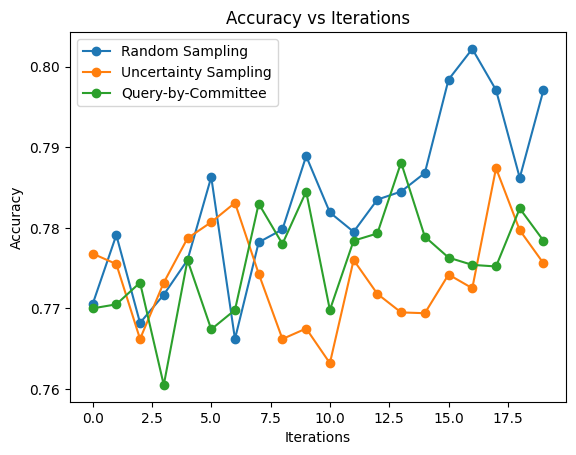

In [37]:
iterations=np.arange(0,20,1)

plt.plot(iterations,task1_results,label="Random Sampling",marker = "o")
plt.plot(iterations,task2_results,label="Uncertainty Sampling",marker = "o")
plt.plot(iterations,task4_results,label="Query-by-Committee",marker = "o")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Iterations")
plt.legend()
plt.show()